# ハッシュタグのカテゴリ分類の性能比較

In [1]:
import pandas as pd
df = pd.read_csv('input/hashtags.csv')
df_category = pd.DataFrame(df['category'].unique(), columns=['category'])
print(df.groupby('category').count())

              hashtag
category             
アート・デザイン           45
クッキング・レシピ          55
サイエンス・科学           39
スポーツ               49
テクノロジー・ガジェット       50
ビジネス・経済            43
ファッション・ビューティ       43
ブック・文学             38
ライフスタイル・生活         38
健康・ウェルネス           44
政治・社会問題            53
教育・学習              41
旅行・アウトドア           51
映画・ドラマ             51
音楽                 55


## ハッシュタグをベクトルに変換する

In [2]:
import torch
from abc import ABC, abstractmethod
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertModel, BertTokenizer

class EmbeddingModel(ABC):
    @abstractmethod
    def convert_to_vector(self, text):
        pass

class BERTModel(EmbeddingModel):
    def __init__(self, model_name="bert-base-uncased"):
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertModel.from_pretrained(model_name)
        
    def convert_to_vector(self, text):
        inputs = self.tokenizer(text, return_tensors="pt")
        with torch.no_grad():
            outputs = self.model(**inputs)
        vector = outputs.last_hidden_state[0, 0, :].numpy().tolist()
        return vector


In [3]:
import time

def add_vector_column(df: pd.DataFrame, model: EmbeddingModel, column: str) -> pd.DataFrame:
    start_time = time.time()

    # 文字列をベクトルに変換して新しい列に追加
    df[column+'_vector'] = df[column].apply(model.convert_to_vector)

    # 処理時間の計測終了と結果の出力
    elapsed_time = time.time() - start_time
    print(f"Elapsed time: {elapsed_time} seconds")

    return df

## ベクトルから最も類似するカテゴリを計算する

In [4]:
import numpy as np

def predict_category(df_hashtag: pd.DataFrame, df_category: pd.DataFrame) -> pd.DataFrame:
    # ベクトルのリストを取得し、NumPy配列に変換
    hashtag_vectors = np.array(df_hashtag['hashtag_vector'].tolist())
    category_vectors = np.array(df_category['category_vector'].tolist())

    # 各ハッシュタグベクトルと全カテゴリベクトルのコサイン類似度を計算
    cosine_similarities = cosine_similarity(hashtag_vectors, category_vectors)

    # 最も類似度が高いカテゴリのインデックスを取得
    predicted_category_indices = np.argmax(cosine_similarities, axis=1)

    # 最大類似度を取得
    max_similarities = np.max(cosine_similarities, axis=1)

    # 予測カテゴリを取得
    predicted_categories = df_category['category'].iloc[predicted_category_indices].values

    # df_hashtagに新しい列を追加
    df_hashtag['predict_category'] = predicted_categories
    df_hashtag['cosine_similarity'] = max_similarities

    return df_hashtag

## カテゴリ分類結果の評価

各評価指標

- **Accuracy（精度）**: Accuracyはモデルがクラスを正しく予測した割合です。すべての真正（真のクラスが正で予測も正）と真陰性（真のクラスが負で予測も負）の数を、全てのケースの数で割ったものになります。ただし、各クラスのサンプル数がバランスしていない場合（不均衡データ）には、この指標は誤解を招く可能性があります。

- **Precision（適合率）**: Precisionは、モデルが正と予測したサンプルのうち、実際に正であったサンプルの割合を示します。偽陽性（実際は負だが、予測は正）を避けることが重要な場合（例えば、スパムメールのフィルタリング）に特に役立つ指標です。

- **Recall（再現率）**: Recallは、実際の正のサンプルのうち、モデルが正と予測したサンプルの割合を示します。偽陰性（実際は正だが、予測は負）を避けることが重要な場合（例えば、病気の診断）に特に役立つ指標です。

- **F1 Score（F1スコア）**: F1 ScoreはPrecisionとRecallの調和平均をとったもので、これら2つの評価指標のバランスを示します。F1スコアは、PrecisionとRecallの両方が重要な場合に特に有用です。F1スコアは1に近いほど良い性能を示し、0に近いほど低い性能を示します。

混同行列のヒートマップ

- **数字**: 数字は各セルの具体的な値を示しています。つまり、特定の「実際のクラス」（行）と「予測されたクラス」（列）の組み合わせがデータセット内で何回発生したかを示しています。
- **色の濃さ**: 色の濃さはそのセルの値が相対的にどの程度大きいかを視覚的に表現しています。色が濃いほど、そのセルの値が大きい（つまり、その「実際のクラス」vs「予測されたクラス」の組み合わせが多く発生した）ことを意味します。これにより、一見してモデルがどのクラスをどの程度正しく予測できたか、またどのクラスで最も間違いが多かったかなど、全体のパターンを把握することが容易になります。

In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

def evaluation(df_predicted: pd.DataFrame):
    # 予測と実際のカテゴリを取得
    y_true = df_predicted['category']
    y_pred = df_predicted['predict_category']

    # 評価指標の計算
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    print(f'Accuracy: {accuracy:.2f}\nPrecision: {precision:.2f}\nRecall: {recall:.2f}\nF1 Score: {f1:.2f}')

    # 混同行列の作成
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

### BERTを使ったカテゴリ分類

In [6]:
bert_model = BERTModel()

# ハッシュタグをベクトル変換してcsv出力
df_bert = add_vector_column(df, bert_model, 'hashtag')
df_bert.to_csv('output/hashtags_bert.csv', index=False)

# カテゴリをベクトル変換してcsv出力
df_category_bert = add_vector_column(df_category, bert_model, 'category')
df_category_bert.to_csv('output/categories_bert.csv', index=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Elapsed time: 77.51746821403503 seconds
Elapsed time: 1.5451056957244873 seconds


In [7]:
df_bert_predicted = predict_category(df_bert, df_category_bert)
df_bert_predicted.to_csv('output/hashtags_bert_predicted.csv', index=False)
df_bert_predicted.head()

,hashtag,category,hashtag_vector,predict_category,cosine_similarity
0,サッカー,スポーツ,"[-0.4107682406902313, -0.5052114129066467, -0....",アート・デザイン,0.952842
1,野球,スポーツ,"[-0.2615754306316376, 0.09152048081159592, -0....",健康・ウェルネス,0.953856
2,ラグビー,スポーツ,"[-0.31610018014907837, -0.8343167304992676, -0...",クッキング・レシピ,0.945390
3,マラソン,スポーツ,"[-0.5356400012969971, 0.5024380683898926, -0.5...",音楽,0.984449
4,バレーボール,スポーツ,"[-0.5938227772712708, -0.46884140372276306, -0...",アート・デザイン,0.968736


In [8]:
!pip install seaborn


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


Accuracy: 0.12
Precision: 0.15
Recall: 0.12
F1 Score: 0.12


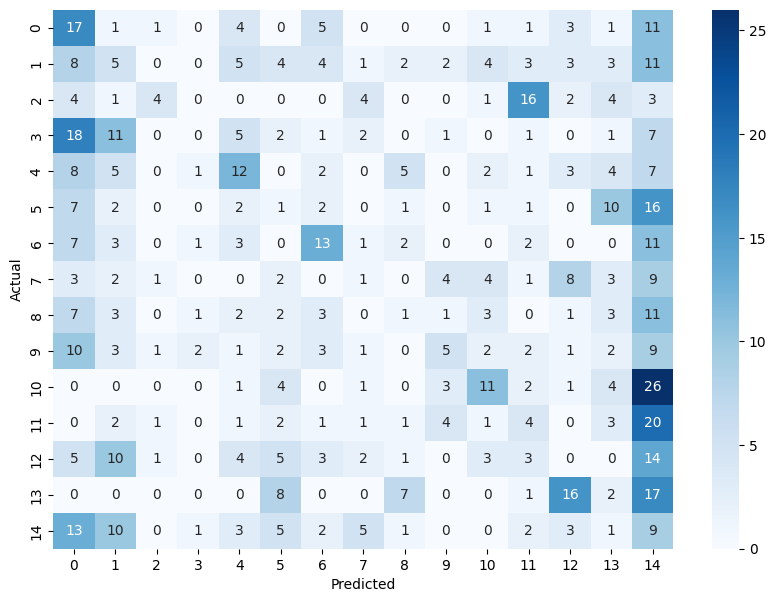

In [11]:
evaluation(df_bert_predicted)